In [549]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline

In [550]:
df = pd.read_csv('pseudo_sigmoid_batches_long.csv')

In [551]:
df

,batch,data_point,value
0,Batch_1,0,0.031108
1,Batch_1,1,0.073149
2,Batch_1,2,0.000000
3,Batch_1,3,0.000000
4,Batch_1,4,0.075847
...,...,...,...
19995,Batch_20,995,0.972519
19996,Batch_20,996,0.997452
19997,Batch_20,997,0.986163
19998,Batch_20,998,0.987074


In [552]:
df_final = df.rename(columns = {'value':'Signal', 'data_point':'Volume', 'batch':'Batch'})
df_final["Campaign"] = "C1"
#df_final = df_final[df_final["Batch"] == "Batch_1"]
df_final


,Batch,Volume,Signal,Campaign
0,Batch_1,0,0.031108,C1
1,Batch_1,1,0.073149,C1
2,Batch_1,2,0.000000,C1
3,Batch_1,3,0.000000,C1
4,Batch_1,4,0.075847,C1
...,...,...,...,...
19995,Batch_20,995,0.972519,C1
19996,Batch_20,996,0.997452,C1
19997,Batch_20,997,0.986163,C1
19998,Batch_20,998,0.987074,C1


In [553]:
# from helper_functions import normalize_signal



In [554]:
from helper_functions import calculate_derivative

In [555]:
def calculate_transwidth(volume, signal):
    normalized_signal = normalize_signal(signal)
    cv_5 = np.interp(0.05, normalized_signal, volume)
    cv_95 = np.interp(0.95, normalized_signal, volume)
    return cv_95 - cv_5

In [556]:
# direct_af.py
from direct_af import calculate_direct_af

In [557]:
def analyze_chromatography(df, column_height):
    results = []
    
    for batch in df['Batch'].unique():
        batch_data = df[df['Batch'] == batch]
        volume = batch_data['Volume'].values
        signal = batch_data['Signal'].values
        
        
        # Calculate the derivative
        dydx = calculate_derivative(volume, signal)
        
        # Find the maximum of the derivative (steepest point of the S-curve)
        max_dydx_index = np.argmax(dydx)
        max_dydx = dydx[max_dydx_index]
        
        # Calculate metrics based on the derivative
        transwidth = calculate_transwidth(volume, signal)
        direct_af = calculate_direct_af(volume, signal)
        
        results.append({
            'Batch': batch,
            'Max_Slope': max_dydx,
            'Transwidth': transwidth,
            'Direct_Af': direct_af
        })
    
    return pd.DataFrame(results)

In [558]:
def establish_control_limits(metrics, n=15):
    control_limits = {}
    for column in metrics.columns:
        if column != 'Batch':
            data = metrics[column].iloc[:n]
            mean = data.mean()
            std = data.std()
            ucl = mean + 3 * std
            lcl = mean - 3 * std
            control_limits[column] = {'mean': mean, 'ucl': ucl, 'lcl': lcl}
    return control_limits

/var/folders/3_/961pfffd04j0z8lxk9dhpftm0000gn/T/ipykernel_73129/919835720.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('Dark2')  # You can change 'tab10' to other colormaps if needed


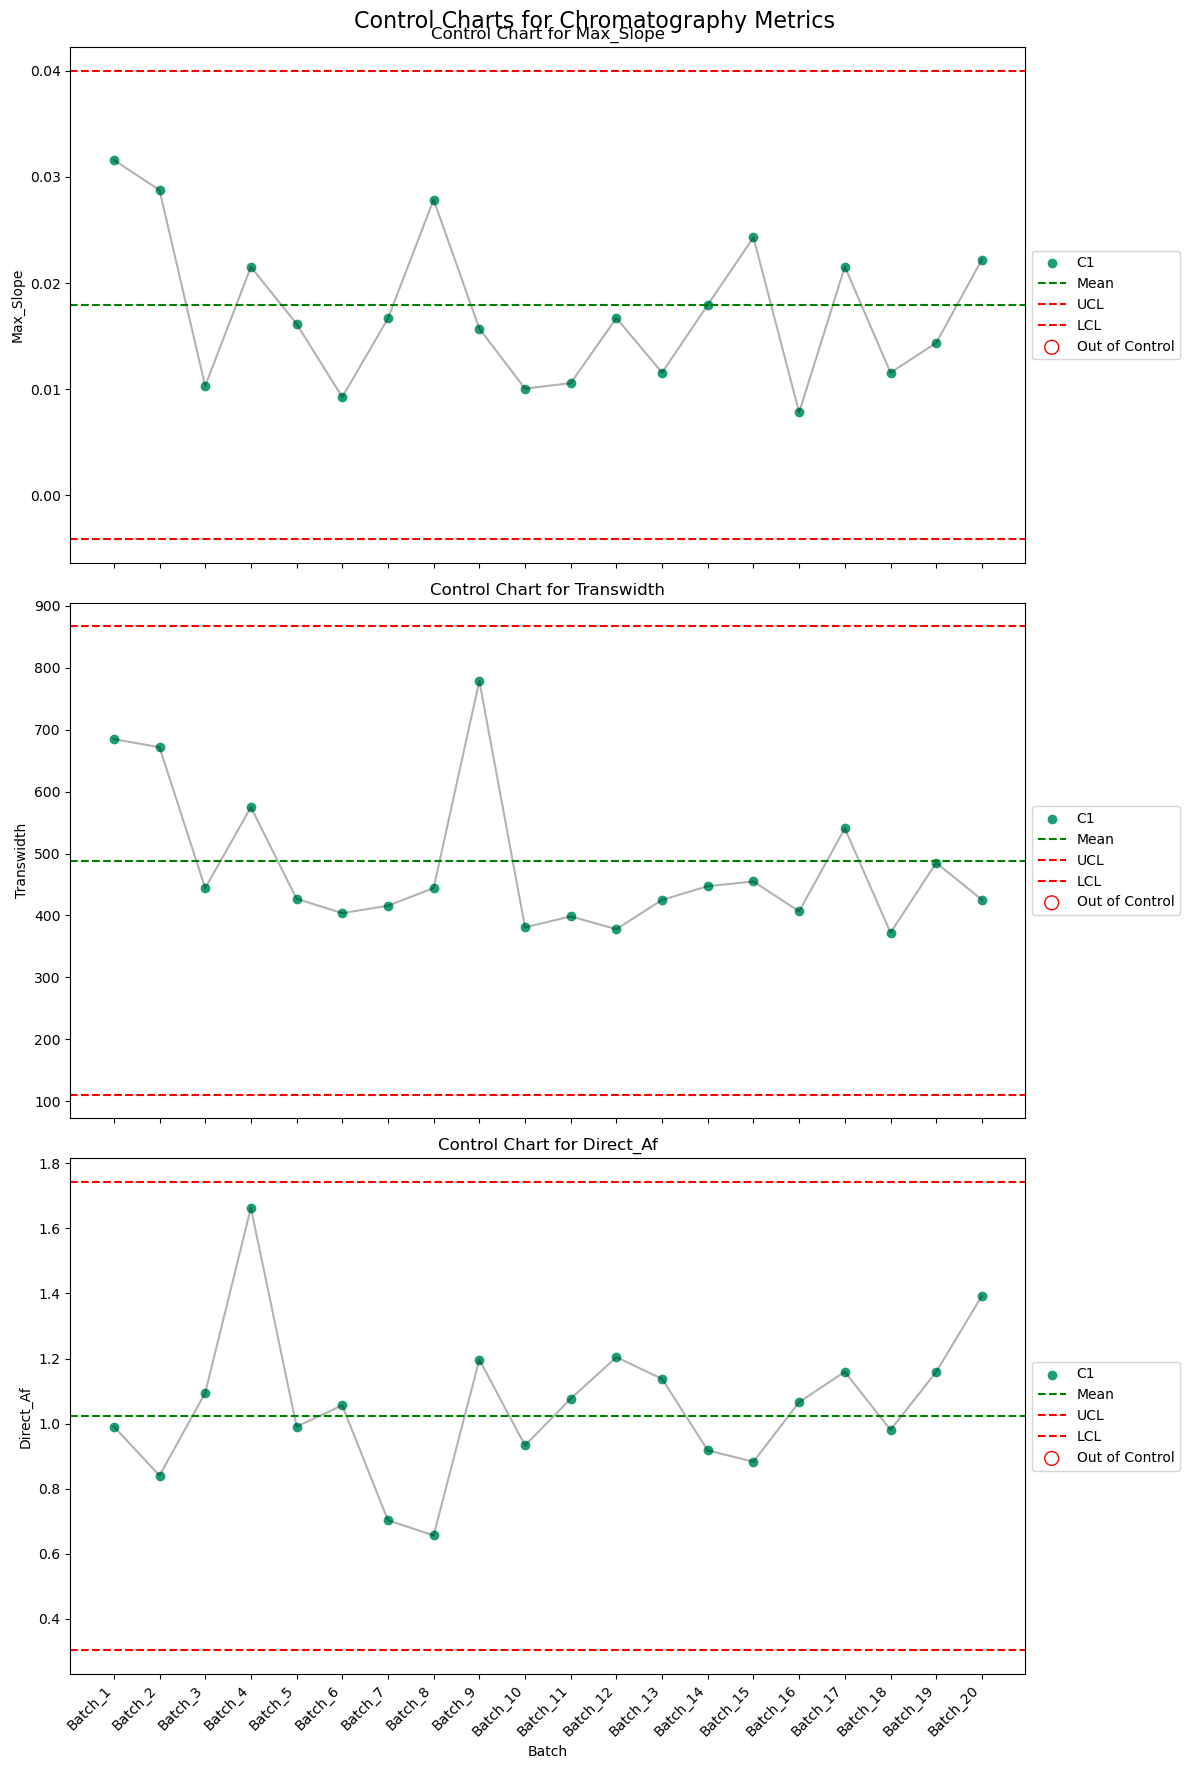

In [559]:
results = analyze_chromatography(df_final, 20)
control_limits = establish_control_limits(results)
create_control_charts(results, control_limits, df_final)

# Plots
note the filtering/params supplied may be different than above

NameError: name 'batch_number' is not defined

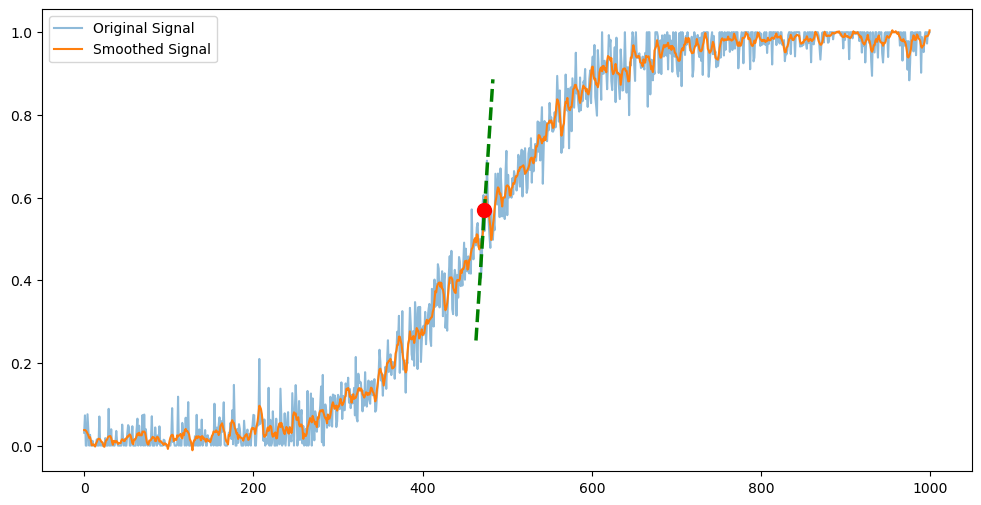

In [564]:
def plot_max_slope(df, batch):
    # Filter the data for the specified batch
    batch_data = df[df['Batch'] == batch]
    
    # Sort the data by Volume
    batch_data = batch_data.sort_values('Volume')
    
    # Extract volume and signal data
    volume = batch_data['Volume'].values
    signal = batch_data['Signal'].values
    
    # Smooth the signal
    signal_smooth = savgol_filter(signal, window_length=11, polyorder=3)
    
    # Calculate the derivative
    dydx = np.gradient(signal_smooth, volume)
    
    # Find the index of maximum slope
    max_slope_index = np.argmax(dydx)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot the original data
    sns.lineplot(x=volume, y=signal, label='Original Signal', alpha=0.5)
    
    # Plot the smoothed data
    sns.lineplot(x=volume, y=signal_smooth, label='Smoothed Signal')
    
    # Highlight the point of maximum slope
    plt.scatter(volume[max_slope_index], signal_smooth[max_slope_index], 
                color='red', s=100, zorder=5, label='Max Slope Point')
    
    # Add a more prominent tangent line at the point of maximum slope
    tangent_x = np.array([volume[max_slope_index] - 10, volume[max_slope_index] + 10])
    tangent_y = dydx[max_slope_index] * (tangent_x - volume[max_slope_index]) + signal_smooth[max_slope_index]
    
    
    
    # Plot the main tangent line
    plt.plot(tangent_x, tangent_y, color='green', linestyle='--', linewidth=2.5, label='Tangent at Max Slope')
    
    plt.title(f'Signal vs Volume for {batch} with Max Slope Visualization')
    plt.xlabel('Volume')
    plt.ylabel('Signal')
    plt.legend()
    
    # Add text annotation for max slope value
    plt.annotate(f'Max Slope: {dydx[max_slope_index]:.2f}', 
                 xy=(volume[max_slope_index], signal_smooth[max_slope_index]),
                 xytext=(10, 30), textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    
    plt.show()

# Example usage:
plot_max_slope(df_final, 'Batch_1')  # Plot for Batch 1

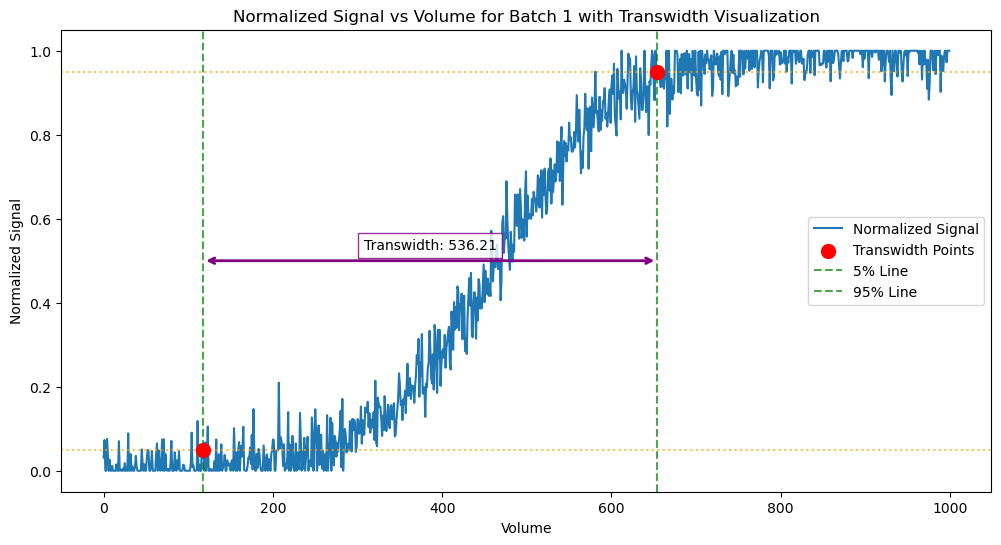

Calculated Transwidth: 536.21


In [537]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

def normalize_signal(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

def calculate_and_plot_transwidth(df, batch_number):
    # Filter the data for the specified batch
    batch_data = df[df['Batch'] == f'Batch_{batch_number}']
    
    # Sort the data by Volume
    batch_data = batch_data.sort_values('Volume')
    
    # Extract volume and signal data
    volume = batch_data['Volume'].values
    signal = batch_data['Signal'].values
    
    # Normalize the signal
    normalized_signal = normalize_signal(signal)
    
    # Create interpolation function
    interp_func = interp1d(normalized_signal, volume, kind='linear')
    
    # Calculate Transwidth
    cv_5 = interp_func(0.05)
    cv_95 = interp_func(0.95)
    transwidth = cv_95 - cv_5
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot the normalized signal
    sns.lineplot(x=volume, y=normalized_signal, label='Normalized Signal')
    
    # Highlight the 5% and 95% points
    plt.scatter([cv_5, cv_95], [0.05, 0.95], color='red', s=100, zorder=5, label='Transwidth Points')
    
    # Add vertical lines at 5% and 95% points
    plt.axvline(x=cv_5, color='green', linestyle='--', alpha=0.7, label='5% Line')
    plt.axvline(x=cv_95, color='green', linestyle='--', alpha=0.7, label='95% Line')
    
    # Add horizontal lines at 5% and 95% levels
    plt.axhline(y=0.05, color='orange', linestyle=':', alpha=0.7)
    plt.axhline(y=0.95, color='orange', linestyle=':', alpha=0.7)
    
    # Add arrow to show Transwidth
    plt.annotate('', xy=(cv_95, 0.5), xytext=(cv_5, 0.5),
                 arrowprops=dict(arrowstyle='<->', color='purple', lw=2))
    
    plt.title(f'Normalized Signal vs Volume for Batch {batch_number} with Transwidth Visualization')
    plt.xlabel('Volume')
    plt.ylabel('Normalized Signal')
    plt.legend()
    
    # Add text annotation for Transwidth value
    plt.text((cv_5 + cv_95) / 2, 0.52, f'Transwidth: {transwidth:.2f}', 
             horizontalalignment='center', verticalalignment='bottom',
             bbox=dict(facecolor='white', edgecolor='purple', alpha=0.8))
    
    plt.show()
    
    return transwidth

# Example usage:
transwidth = calculate_and_plot_transwidth(df_final, 1)  # Plot for Batch 1
print(f"Calculated Transwidth: {transwidth:.2f}")

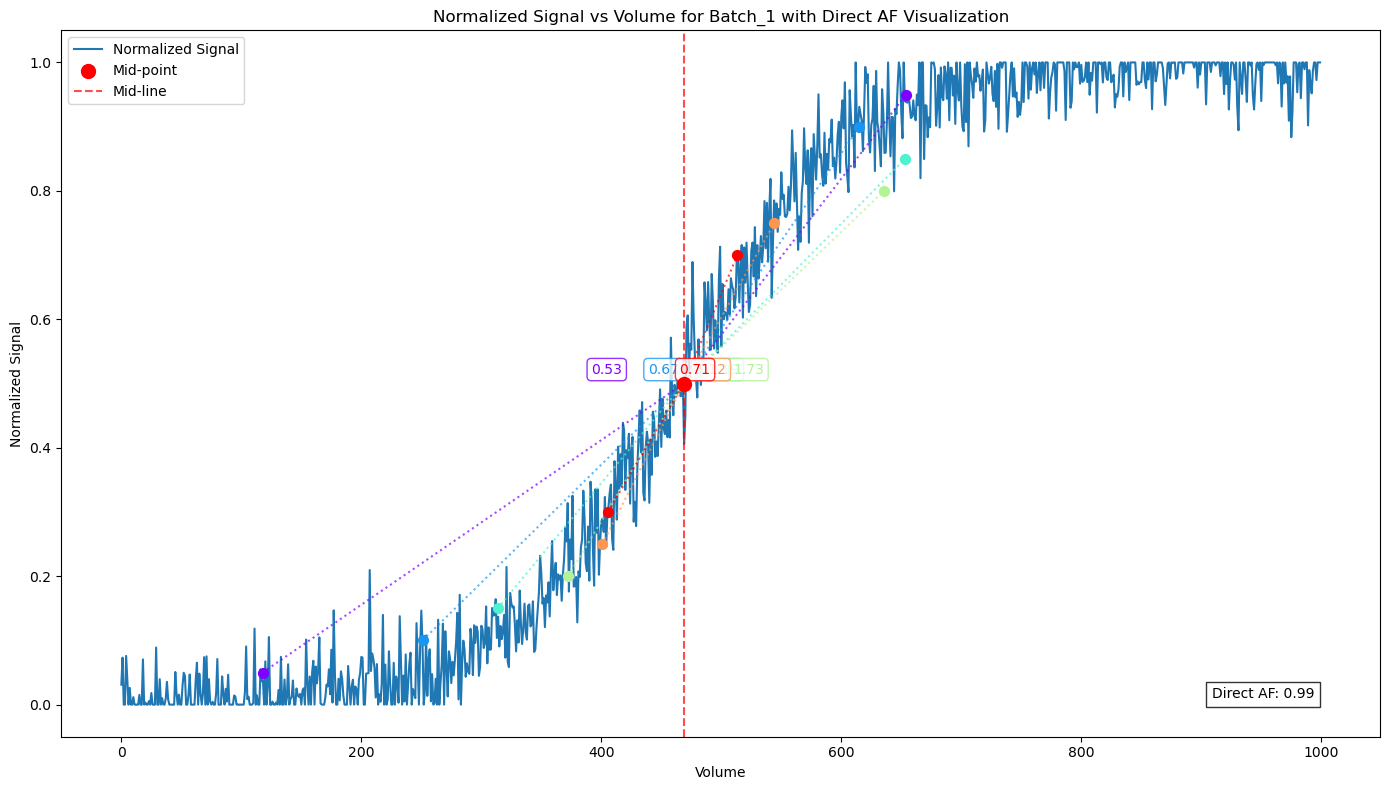

Calculated Direct AF: 0.99


In [562]:
# direct_af.py
from direct_af import calculate_and_plot_direct_af

# Example usage:
direct_af = calculate_and_plot_direct_af(df_final, "Batch_1")  # Plot for Batch 1
print(f"Calculated Direct AF: {direct_af:.2f}")

In [539]:
temp = df_final[df_final['Batch'] == 'Batch_2']

In [540]:
temp


,Batch,Volume,Signal,Campaign
1000,Batch_2,0,0.002829,C1
1001,Batch_2,1,0.000000,C1
1002,Batch_2,2,0.033130,C1
1003,Batch_2,3,0.018670,C1
1004,Batch_2,4,0.042476,C1
...,...,...,...,...
1995,Batch_2,995,0.958156,C1
1996,Batch_2,996,0.992263,C1
1997,Batch_2,997,0.964655,C1
1998,Batch_2,998,0.967964,C1


In [541]:
def calculate_direct_af(volume, signal):
    # Sort the data by Volume
   

    # Normalize the signal
    normalized_signal = normalize_signal(signal)

    # Create interpolation function
    interp_func = interp1d(normalized_signal, volume, kind='linear', bounds_error=False, fill_value="extrapolate")

    cv_mid = interp_func(0.5)
    
    return cv_mid

In [542]:
calculate_direct_af(temp['Volume'], temp['Signal'])

array(375.24034166)

In [543]:
def calculate_direct_af(volume, signal):
    # Sort the data by Volume
    

    # Normalize the signal
    normalized_signal = normalize_signal(signal)

    cv_mid = np.interp(0.5, normalized_signal, volume) 
    
    return cv_mid

In [544]:
calculate_direct_af(temp['Volume'], temp['Signal'])

361.686121130286

In [545]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt



def visualize_interpolation(volume, signal):
    

    # Normalize the signal
    normalized_signal = normalize_signal(signal)

    # Create interpolation functions
    interp_func_scipy = interp1d(normalized_signal, volume, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # Generate points for smooth curve
    x_smooth = np.linspace(0, 1, 1000)
    y_smooth_scipy = interp_func_scipy(x_smooth)
    y_smooth_numpy = np.interp(x_smooth, normalized_signal, volume)

    # Calculate midpoints
    cv_mid_scipy = interp_func_scipy(0.5)
    cv_mid_numpy = np.interp(0.5, normalized_signal, volume)

    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.scatter(normalized_signal, volume, color='black', label='Original Data')
    plt.plot(x_smooth, y_smooth_scipy, color='blue', label='SciPy Interpolation')
    plt.plot(x_smooth, y_smooth_numpy, color='red', linestyle='--', label='NumPy Interpolation')
    plt.scatter([0.5], [cv_mid_scipy], color='blue', s=100, marker='o', label='SciPy Midpoint')
    plt.scatter([0.5], [cv_mid_numpy], color='red', s=100, marker='s', label='NumPy Midpoint')

    plt.xlabel('Normalized Signal')
    plt.ylabel('Volume')
    plt.title('Interpolation Visualization')
    plt.legend()
    plt.grid(True)

    # Add text annotations for midpoint values
    plt.annotate(f'SciPy: {cv_mid_scipy:.2f}', (0.5, cv_mid_scipy), xytext=(10, 10), 
                 textcoords='offset points', ha='left', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
    plt.annotate(f'NumPy: {cv_mid_numpy:.2f}', (0.5, cv_mid_numpy), xytext=(10, -10), 
                 textcoords='offset points', ha='left', va='top',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    plt.show()



/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


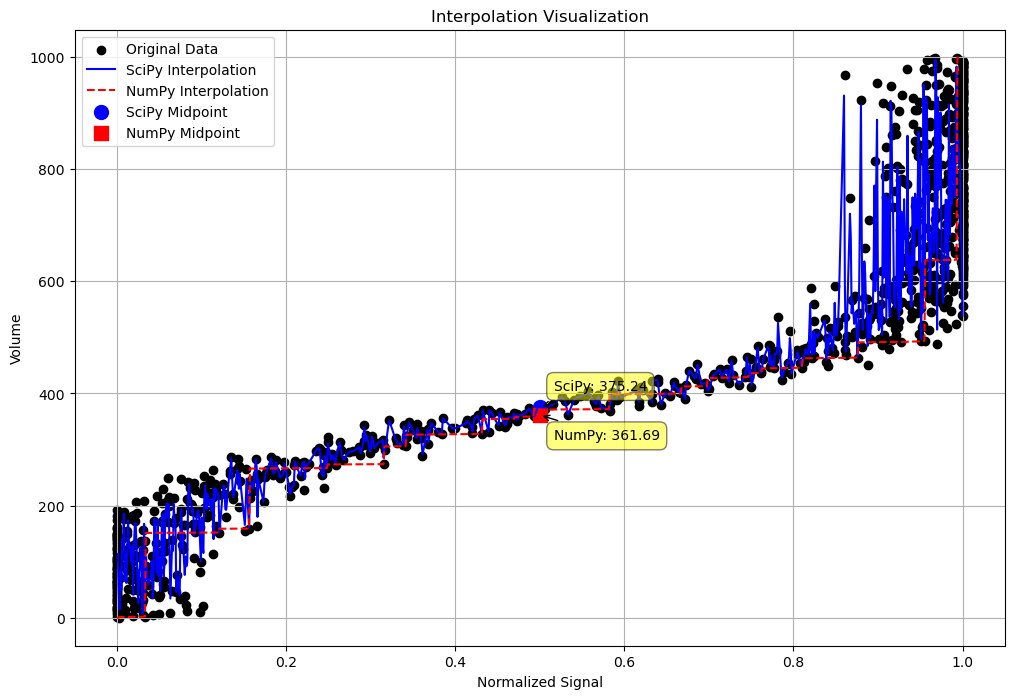

In [546]:
visualize_interpolation(temp['Volume'], temp['Signal'])